In [105]:
import numpy as np
import os
import os.path as osp
import glob
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import cv2

from make_dataset_utils import get_data_dir
from camera_utils import load_ts
from ev_buffer import EventBuffer
from eimg_maker import ev_to_eimg, eimg_to_img

def get_paths():
    scene = "checkerboard_2_tilt_fb_000000"
    rgb_data_dir, evs_data_dir = get_data_dir(scene, "rgb"), get_data_dir(scene, "evs")

    return rgb_data_dir, evs_data_dir

rgb_data_dir, evs_data_dir = get_paths()

reproj_npz_f = osp.join(evs_data_dir, "dataset_reprojected_classical.npz")
reproj_npz = np.load(reproj_npz_f, allow_pickle=True)
keys = list(reproj_npz.keys())
rgb_keys = sorted([e for e in keys if not("mask" in e)])
msk_keys = sorted([e for e in keys if "mask" in e])
frame_ts = reproj_npz["t"]
buffer = EventBuffer(evs_data_dir)

In [106]:
idx = len(rgb_keys)//2
get_img = lambda i : reproj_npz[rgb_keys[i]]
get_msk = lambda i : reproj_npz[msk_keys[i]]

prev_img, next_img = get_img(idx), get_img(idx + 1)
prev_msk, next_msk = get_msk(idx), get_msk(idx + 1)
msk = prev_msk & next_msk

In [107]:
t_st, t_end = frame_ts[idx], frame_ts[idx+1]
ts, xs, ys, ps = buffer.retrieve_data(t_st, t_end, is_far=True)
eimg_img = eimg_to_img(ev_to_eimg(xs, ys, ps), col=False)

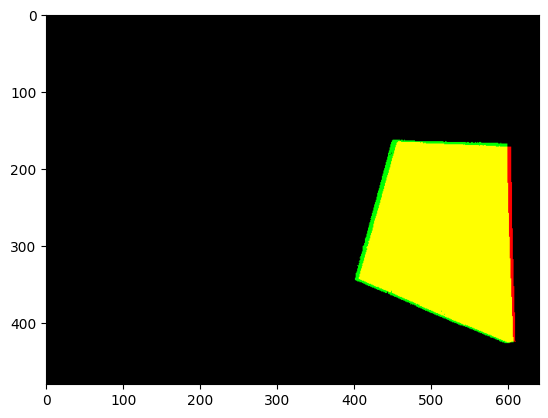

In [108]:
loc_msk = msk[ys, xs]
x, y = xs[loc_msk], ys[loc_msk]

msk_img = np.zeros((*msk.shape, 3)).astype(np.uint8)
msk_img[prev_msk,0] = 255
msk_img[next_msk,1] = 255
plt.imshow(msk_img)

In [109]:
## Coarse opt as described
to_numpy = lambda x : x.detach().cpu().numpy()
class CoarseEstimator(nn.Module):

    def __init__(self, xs, ys, ps, prev_img, next_img, prev_msk, next_msk, n_iter = 10000, show_pbar=True):
        """
        xs, ys, ps (np.array): events in between img_prev_t, img_next_t
        img_prev, img_next (np.array): image of shape (h,w, *)
        msk (np.array): mask of shape (h,w)
        """

        super(CoarseEstimator, self).__init__()
        self.EPS = 1e-6
        self.n_iter = n_iter
        self.show_bar = show_pbar
        self.ori_xs, self.ori_ys, self.ori_ps = xs, ys, ps
        self.ori_prev_img, self.ori_next_img = prev_img, next_img
        self.prev_msk, self.next_msk = prev_msk, next_msk
        self.msk = self.prev_msk & self.next_msk
        self._apply_msk_to_all_ori_frame_data()
        
        
        self._init_images(prev_img, next_img, msk)
        self._init_events(xs, ys, ps, msk)
        self._init_est_thresh(xs, ys, msk)
    
    def _apply_msk_to_all_ori_frame_data(self):
        self.ori_prev_img = np.copy(self.ori_prev_img)
        self.ori_next_img = np.copy(self.ori_next_img)

        self.ori_prev_img[~self.msk] = 0
        self.ori_next_img[~self.msk] = 0


    def _init_est_thresh(self, xs=None, ys=None, ps=None):
        self.pos_thresh = torch.nn.Parameter(torch.tensor([0.2]))
        self.neg_thresh = torch.nn.Parameter(torch.tensor([0.2]))

        self.opt = torch.optim.SGD([self.pos_thresh, self.neg_thresh], lr=1e-2)

    def _format_img(self, img):
        if len(img.shape) == 3:
            img = (cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)/255)

        return img
    
    def _init_images(self, prev_img, next_img, msk):
        

        self.prev_img = torch.from_numpy(self._format_img(prev_img)[msk]).float()
        self.next_img = torch.from_numpy(self._format_img(next_img)[msk]).float()

        self.prev_log, self.next_log = torch.log(self.prev_img + self.EPS), torch.log(self.next_img + self.EPS)


    def _init_events(self, xs, ys, ps, msk):
        self.coor_msk = msk[ys, xs]
        xs, ys, ps = [e[self.coor_msk] for e in [xs, ys, ps]]
        
        pos_cond = ps == 1
        neg_cond = ps == 0
        self.np_pos_img = ev_to_eimg(xs[pos_cond], ys[pos_cond], ps[pos_cond])
        self.np_neg_img = ev_to_eimg(xs[neg_cond], ys[neg_cond], ps[neg_cond])

        self.np_pos_img[~self.msk] = 0
        self.np_neg_img[~self.msk] = 0

        self.pos_img = torch.from_numpy(self.np_pos_img[msk])
        self.neg_img = torch.from_numpy(self.np_neg_img[msk])
        self.n_evs = len(xs)

    def estimate(self):
        for step in tqdm(range(self.n_iter)):
            self.opt.zero_grad()
            pred_log = self.prev_log + self.pos_thresh*self.pos_img + self.neg_thresh*self.neg_img
            loss = ((pred_log - self.next_log)**2).sum()/self.n_evs
            loss.backward()
            self.opt.step()
            
            if step%5000 == 0:
                # pbar.set_description(f"loss:{loss.detach().cpu().item()}")
                print("loss:", loss.detach().cpu().item())

    def validate(self):
        pos_thresh, neg_thresh = to_numpy(self.pos_thresh), to_numpy(self.neg_thresh)
        pred_log = np.log(self._format_img(self.ori_prev_img) + self.EPS) + pos_thresh*self.np_pos_img + neg_thresh * self.np_neg_img
        pred_img = np.exp(pred_log)
        pred_err = np.abs(pred_img - self._format_img(self.ori_next_img)).mean()
        base_err = np.abs(self._format_img(self.ori_prev_img) - self._format_img(self.ori_next_img)).mean()

        print(f"base err: {base_err}, pred err: {pred_err}")



In [110]:
est = CoarseEstimator(xs, ys, ps, prev_img, next_img, prev_msk, next_msk)
est.estimate()

  7%|▋         | 731/10000 [00:00<00:02, 3651.55it/s]

loss: 0.5056347250938416


 55%|█████▍    | 5483/10000 [00:01<00:01, 3651.15it/s]

loss: 0.49605002999305725


100%|██████████| 10000/10000 [00:02<00:00, 3655.13it/s]


In [111]:
est.validate()

base err: 0.01938420394199346, pred err: 0.01635489448873003
